In [20]:
# Importing dependencies
import warnings
warnings.filterwarnings('ignore')


import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

pd.set_option("display.precision",2)
pd.set_option("display.max_columns",None)

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import validation_curve, learning_curve

import pickle

In [4]:
# loading the dataset
df = pd.read_pickle('./pickled/Train_set_scaled')

In [5]:
df.head()

,index,ID,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Marital Status_Divorced,Marital Status_Married,Marital Status_Single,Marital Status_Together,Marital Status_Widow,Year_Birth,Education,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Z_CostContact,Z_Revenue
0,1998,5370,1,0,0,0,0,0,0,0.0,1.0,0.0,0.0,0.0,0.34,1.61,-0.88,1.02,-0.93,0.75,-0.38,-0.19,-0.59,-0.10,-0.69,-0.49,-0.41,0.88,1.07,-0.57,0.06,1.11,0.0,0.0
1,814,6303,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,1.46,1.61,1.87,-0.82,-0.93,-0.57,0.79,0.33,1.18,2.61,0.71,3.27,-0.27,-1.22,0.34,0.80,1.92,-1.78,0.0,0.0
2,1513,9264,0,0,0,0,0,0,0,0.0,1.0,0.0,0.0,0.0,1.46,-0.78,1.29,-0.82,-0.93,-1.23,-1.66,0.36,0.40,2.43,0.66,4.15,2.92,-0.70,-0.03,1.82,0.99,-1.37,0.0,0.0
3,1381,7514,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,-1.11,0.81,0.12,1.02,0.92,0.54,0.86,-0.66,-0.41,-0.58,-0.48,-0.41,-0.31,0.88,-0.39,-0.57,-0.55,0.28,0.0,0.0
4,919,4637,0,0,0,1,0,0,0,0.0,0.0,1.0,0.0,0.0,-1.29,1.61,1.07,-0.82,-0.93,0.23,0.83,1.98,0.95,1.34,2.00,-0.66,-0.54,-0.70,0.70,2.16,0.99,-0.96,0.0,0.0


Lets seperate Train,Test(Validation) Set

In [6]:
df['Target'] = df['AcceptedCmp1']+df['AcceptedCmp2']+df['AcceptedCmp3'] + \
    df['AcceptedCmp4']+df['AcceptedCmp5']+df['Response']

In [7]:
df['Target'].replace(
    df[df['Target']>0]['Target'].values.tolist(),
    1,
    inplace = True
)

In [8]:
X = df.drop(columns=['index', 'ID', 'AcceptedCmp1', 'AcceptedCmp2',
                     'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response', 'Target'])
y = df['Target']

In [9]:
X_train, X_test, y_train, y_valid = train_test_split(
    X, y, test_size=0.25, random_state=42
)

In [10]:
X_train.shape , y_valid.shape

((1327, 26), (443,))

In [11]:
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)

In [12]:
rfc = RandomForestClassifier(random_state=42,n_jobs=-1)

In [13]:
cross_val_score(rfc,X,y,cv=skf,scoring='roc_auc').mean()

0.8350017718190985

In [14]:
rfc.fit(X_train,y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [15]:
rfc_pred = rfc.predict(X_test)
roc_auc_score(y_valid,rfc_pred)

0.7278197262859839

Note:
- Overfitting is happening here!

Lets plot the learning Curve:

In [16]:
# Helper function
alphas = np.logspace(-2, 0, 20)
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, "-", **kwargs)
    plt.fill_between(
        x,
        mu - std,
        mu + std,
        edgecolor="none",
        facecolor=lines[0].get_color(),
        alpha=0.2,
    )

In [17]:
def plot_learning_curve():
    train_sizes = np.linspace(0.05,1,20)
    N_train,val_train,val_test = learning_curve(
        rfc,X,y,train_sizes=train_sizes,cv=skf,shuffle=True,scoring='roc_auc'
    )
    plot_with_err(N_train, val_train, label="training scores")
    plot_with_err(N_train, val_test, label="validation scores")
    plt.xlabel("Training Set Size")
    plt.ylabel("AUC")
    plt.legend()
    plt.grid(True);

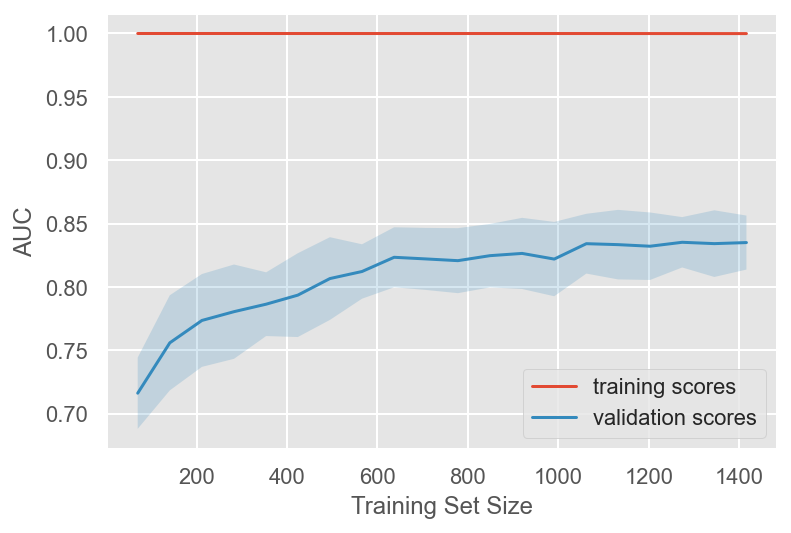

In [18]:
plot_learning_curve()

Seems like more data surely would help our model! 

In [19]:
# Parameters currently in use:
rfc.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

- n_estimators = number of trees in the foreset
- max_features = max number of features considered for splitting a node
- max_depth = max number of levels in each decision tree
- min_samples_split = min number of data points placed in a node before the node is split
- min_samples_leaf = min number of data points allowed in a leaf node
- bootstrap = method for sampling data points (with or without replacement)

In [22]:
# Parameter Grid

# Number of trees in the RF
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
# Number of Features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in the tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
# Minimum number of Samples required to split a node
min_samples_split = [2, 5, 10]
# Miimum number of samples required at each leaf
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Creating the Random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
random_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [23]:

rf_random = RandomizedSearchCV(estimator=rfc, param_distributions=random_grid,
                               n_iter=100, cv=skf, verbose=2, random_state=42, n_jobs=-1)

In [24]:
# Lets fit the model
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [25]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 90,
 'bootstrap': False}

In [29]:
cross_val_score(rf_random.best_estimator_,X,y,cv=skf,scoring='roc_auc').mean()

0.8388848521890555

In [30]:
rfc_pred = rf_random.best_estimator_.predict(X_test)
roc_auc_score(y_valid,rfc_pred)

0.7461197629909287